In [8]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tableone import TableOne, load_dataset

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import tensorflow as tf
import torch

"""import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense"""

'import tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense'

In [9]:
def impute_missing(data_sensors, column):
    before_imputation = data_sensors.copy()

    for index, row in data_sensors.iterrows():
        if pd.isna(row[column]):
            #prev row
            prev = data_sensors.loc[:index].loc[~data_sensors[column].isna()].tail(1)
            #next row
            next = data_sensors.loc[index:].loc[~data_sensors[column].isna()].head(1)

            if not (prev.empty or next.empty):
                mean = round((prev[column].values[0] + next[column].values[0]) / 2, 2)
                data_sensors.at[index, column] = mean

    
    changes = pd.DataFrame(columns=['Index', 'before', 'after'])
    for index, row in before_imputation.iterrows():
        before = row[column]
        after = data_sensors.at[index, column]
        if pd.notna(before) and pd.notna(after) and before != after:
            changes = changes.append({'Index': index, 'before': before, 'after': after}, ignore_index=True)

    return data_sensors, changes

def rename_sensor(data_sensors):

    sensor_ids = ['am3019-testqc2090', 'am307-9074', 'eui-24e124128c147204',
                  'eui-24e124128c147444', 'eui-24e124128c147446',
                  'eui-24e124128c147470', 'eui-24e124128c147499',
                  'eui-24e124128c147500', 'eui-24e124710c408089',
                  'eui-24e124725c461468', 'q4-1003-7456']
    #We will not use Biblio_Filo and AudioLab Data
    sensors_names = ['testqc2090', 'Computer_Room', 'Digital_Lab',
                  'Biblio_Filo', '24e124128c147446',
                  '24e124128c147470', 'AudioLab',
                  'OpenLab_Main_Room', 'OpenLab_Laser_Room',
                  '24e124725c461468', 'Classroom']
    
    mapp = dict(zip(sensor_ids, sensors_names))
    data_sensors['location'] = data_sensors['location'].map(mapp).fillna(data_sensors['location'])
    
    data_sensors = data_sensors[(data_sensors['location'] != 'Biblio_Filo') & (data_sensors['location'] != 'AudioLab')]
    
    return data_sensors


def display_plot(data,x, y, fig_title):
    plt.figure(figsize = (20,7))
    plt.title(fig_title, loc='center', fontsize=20)
    sb.barplot(x = x, y = y, palette = 'cool') 
    plt.tight_layout();



We have loaded the dataframes and modified the formats so that they are similar

In [10]:
data_meteo = pd.read_excel("C:/Users/migue/UAB_EnergyStudy/DataSets_/Meteo - Sensors Data/datos_meteo.xlsx")
data_sensors = pd.read_csv("C:/Users/migue/OneDrive/Escritorio/UAB INTELIGENCIA ARTIFICIAL/Segon Any/2B/nuevo_historic_sensors_data.csv")

data_meteo['Hora'] = data_meteo['Hora'].str.split(' - ').str[0]
data_meteo = data_meteo.rename(columns={'Fecha': 'Date'})
data_meteo = data_meteo.rename(columns={'Hora': 'Hour'})


data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')
data_sensors['Hour'] = pd.to_datetime(data_sensors['Hour'], format= '%H:%M:%S').dt.strftime('%H:%M')
data_sensors = data_sensors.drop(columns=['_measurement'])

In [11]:
data_sensors.shape

(1745335, 5)

We have created the columns based on the _field data to have the dataset more compressed, ordered and with more columns

In [12]:
data_sensors = data_sensors.pivot_table(index=['location', 'Date', 'Hour'], columns='_field', values='_value')
data_sensors = data_sensors.reset_index()
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%d-%m-%Y')
data_sensors = data_sensors.sort_values(by=['location', 'Date', 'Hour'])
data_sensors['Date'] = pd.to_datetime(data_sensors['Date'], format='%Y-%m-%d').dt.strftime('%d-%m-%Y')

data_sensors = data_sensors.drop(columns=["activity","battery","infrared_and_visible", "pm10", "pm2_5", "illumination", "infrared", "light_level"])

In [13]:
data_sensors = rename_sensor(data_sensors)

In [14]:
data_sensors.shape

(193215, 9)

Missing Values

In [15]:
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())
print(data_meteo[data_meteo.columns[data_meteo.isnull().sum()>0]].isnull().sum())

_field
co2               616
humidity          798
o3             129341
pressure        32485
temperature       801
tvoc            32307
dtype: int64
Series([], dtype: float64)


In [16]:
data_sensors, _ = impute_missing(data_sensors, "temperature")
data_sensors, _ = impute_missing(data_sensors, "humidity")
data_sensors, _ = impute_missing(data_sensors, "co2") 
data_sensors, _ = impute_missing(data_sensors, "pressure")
data_sensors, _ = impute_missing(data_sensors, "tvoc")  

In [17]:
#data_sensors.fillna(0, inplace=True)
print(data_sensors[data_sensors.columns[data_sensors.isnull().sum()>0]].isnull().sum())

_field
o3    129341
dtype: int64


Duplicates

In [18]:
data_sensors.duplicated().sum()

0

In [ ]:
data_sensors.describe()

# Recommender System

In [19]:
data_meteo

,Date,Hour,TM,HRM%,PPT,RS
0,25-07-2023,00:00,24.7,73,0.0,0
1,25-07-2023,00:30,24.4,74,0.0,0
2,25-07-2023,01:00,24.1,75,0.0,0
3,25-07-2023,01:30,23.9,75,0.0,0
4,25-07-2023,02:00,23.9,74,0.0,0
...,...,...,...,...,...,...
11995,30-03-2024,21:30,11.9,89,0.0,0
11996,30-03-2024,22:00,12.0,87,0.0,0
11997,30-03-2024,22:30,12.2,88,0.5,0
11998,30-03-2024,23:00,12.7,86,0.0,0


In [20]:
data_sensors

_field,location,Date,Hour,co2,humidity,o3,pressure,temperature,tvoc
24656,testqc2090,25-07-2023,13:50,472.0,36.0,0.05,996.9,27.8,100.0
24657,testqc2090,25-07-2023,14:00,466.0,36.0,0.05,996.9,27.9,100.0
24658,testqc2090,25-07-2023,14:10,466.0,36.0,0.05,996.9,27.9,100.0
24659,testqc2090,25-07-2023,14:20,455.0,36.0,0.05,996.8,27.9,100.0
24660,testqc2090,25-07-2023,14:30,463.0,36.0,0.05,996.7,28.0,100.0
...,...,...,...,...,...,...,...,...,...
219251,Classroom,30-03-2024,11:43,438.0,39.0,NaN,976.1,22.0,173.0
219252,Classroom,30-03-2024,11:53,427.0,38.5,NaN,976.2,22.3,180.0
219253,Classroom,30-03-2024,12:03,433.0,38.0,NaN,976.2,22.5,183.0
219254,Classroom,30-03-2024,12:13,426.0,38.0,NaN,976.2,22.7,184.0


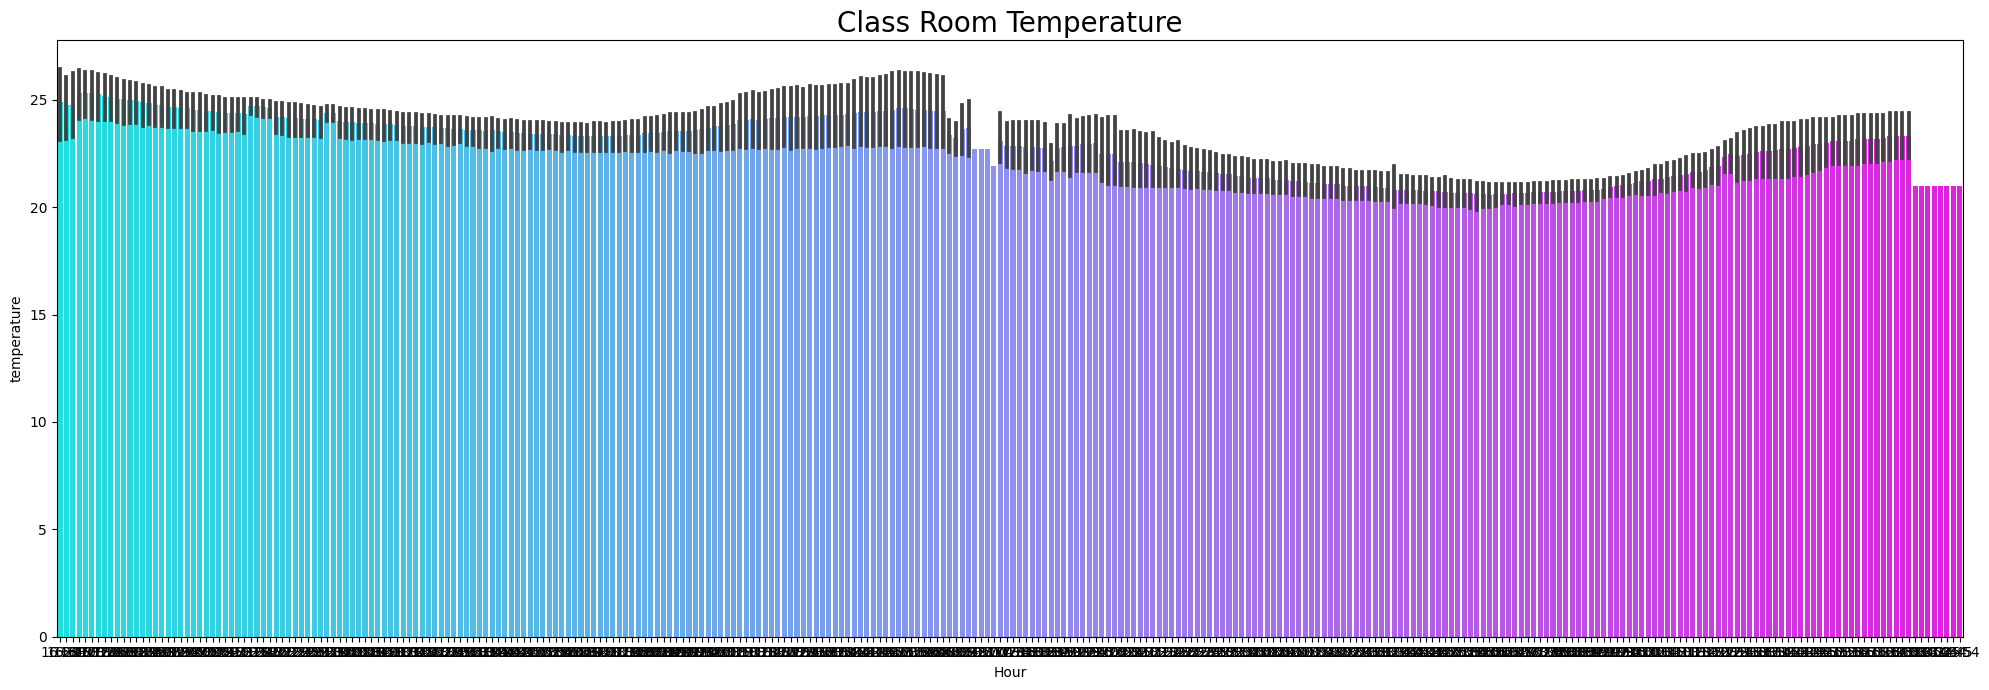

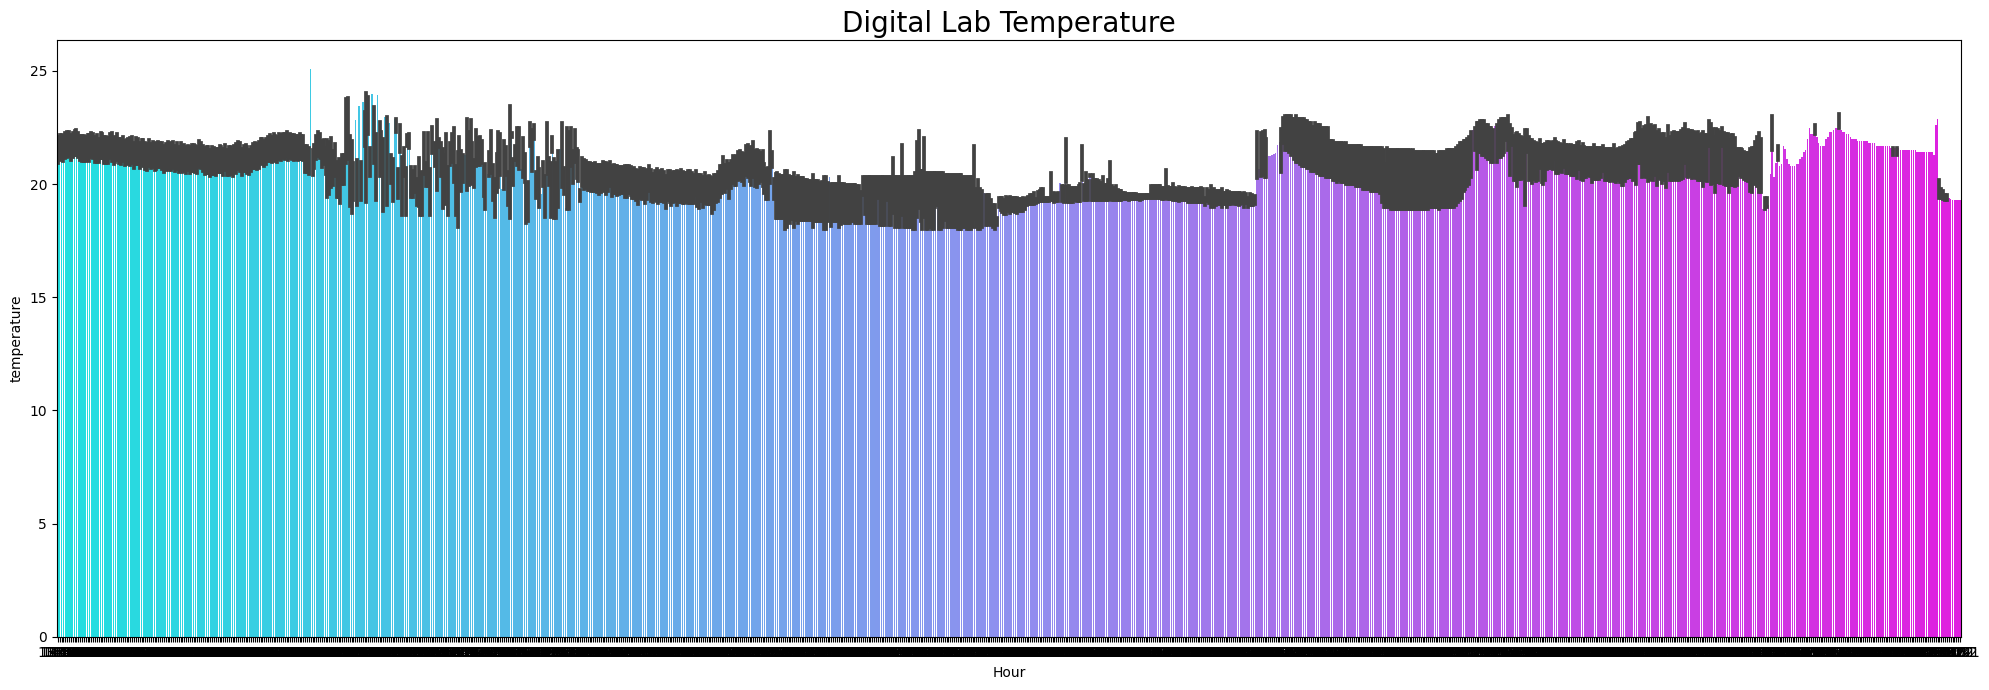

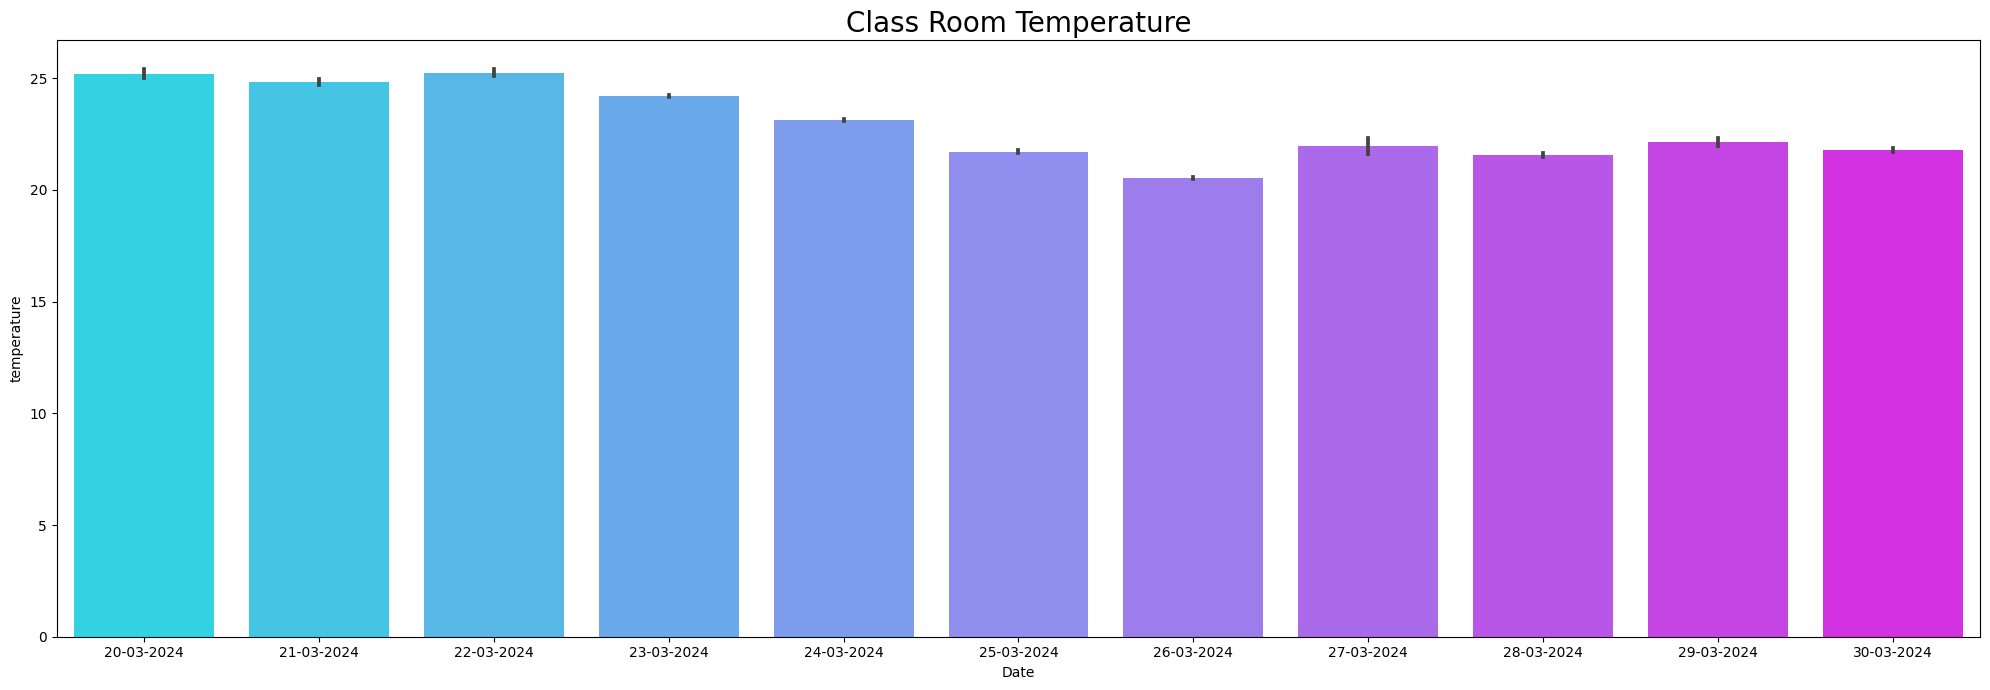

In [21]:
Classroom = data_sensors[data_sensors['location'] == 'Classroom']
Digital_Lab = data_sensors[data_sensors['location'] == 'Digital_Lab']

display_plot(Classroom, Classroom['Hour'], Classroom['temperature'], "Class Room Temperature")
display_plot(Digital_Lab, Digital_Lab['Hour'], Digital_Lab['temperature'], "Digital Lab Temperature")
display_plot(Classroom, Classroom['Date'], Classroom['temperature'], "Class Room Temperature")

C:\Users\migue\AppData\Local\Temp\ipykernel_40636\1816206526.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(Classroom.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)


<AxesSubplot:xlabel='_field', ylabel='_field'>

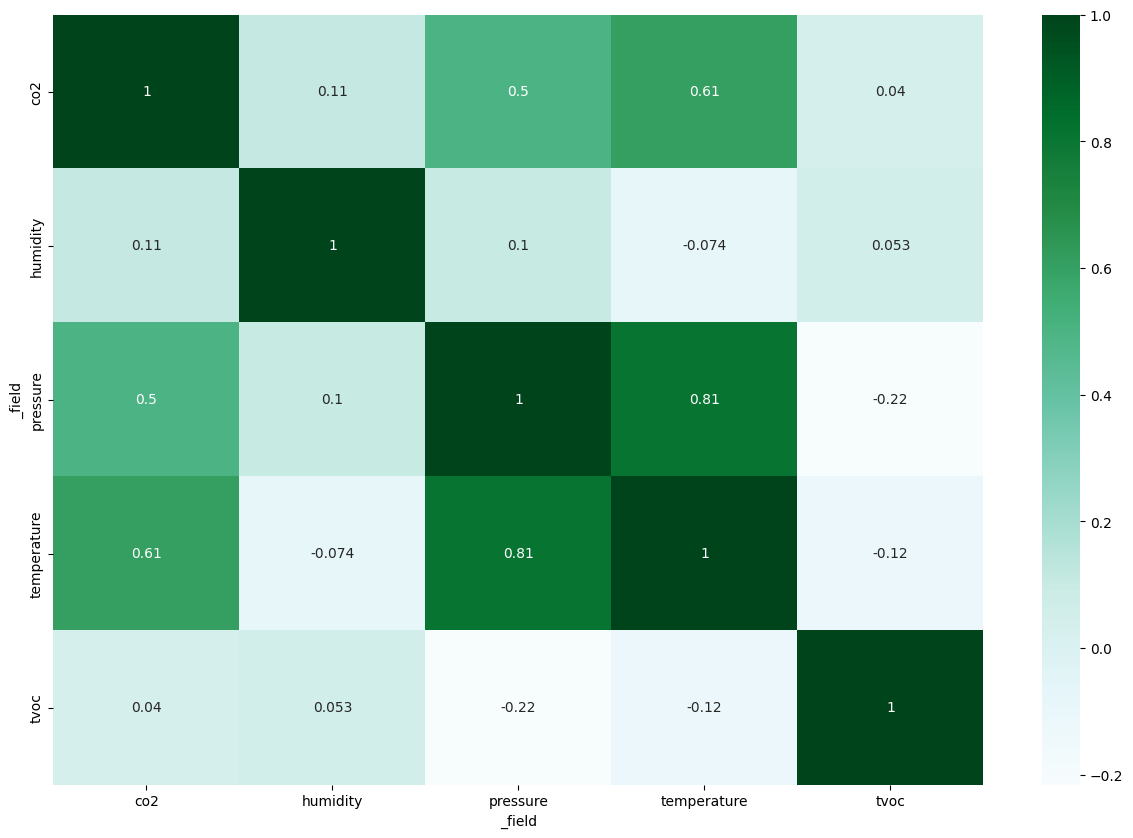

In [22]:
plt.figure(figsize=(15, 10))
sb.heatmap(Classroom.drop(['o3'], axis=1).corr(), cmap='BuGn', annot=True)

In [35]:
Classroom

_field,location,Date,Hour,co2,humidity,o3,pressure,temperature,tvoc
217954,Classroom,20-03-2024,16:28,673.00,39.0,NaN,1002.4,27.3,76.0
217955,Classroom,20-03-2024,16:38,629.50,39.5,NaN,1002.4,26.6,76.0
217956,Classroom,20-03-2024,16:48,607.75,39.0,NaN,1002.4,26.5,76.0
217957,Classroom,20-03-2024,16:58,596.88,39.0,NaN,1002.4,26.5,76.0
217958,Classroom,20-03-2024,17:08,591.44,39.0,NaN,1002.4,26.4,76.0
...,...,...,...,...,...,...,...,...,...
219251,Classroom,30-03-2024,11:43,438.00,39.0,NaN,976.1,22.0,173.0
219252,Classroom,30-03-2024,11:53,427.00,38.5,NaN,976.2,22.3,180.0
219253,Classroom,30-03-2024,12:03,433.00,38.0,NaN,976.2,22.5,183.0
219254,Classroom,30-03-2024,12:13,426.00,38.0,NaN,976.2,22.7,184.0


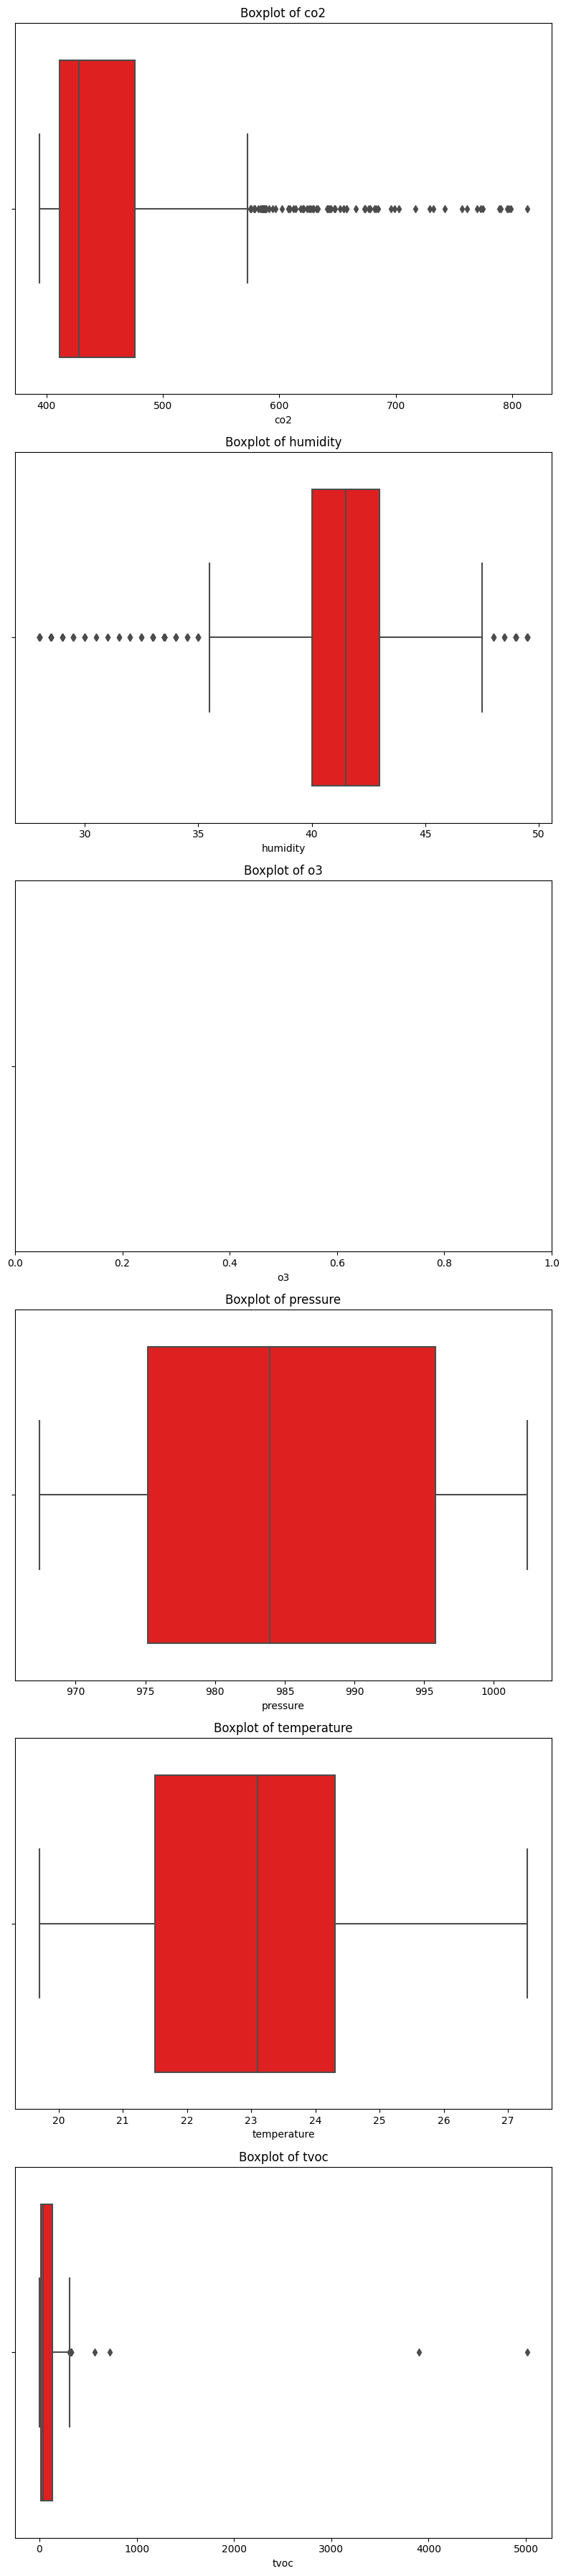

_field,location,Date,Hour,co2,humidity,o3,pressure,temperature,tvoc
217954,Classroom,20-03-2024,16:28,673.00,39.0,NaN,1002.4,27.3,76.0
217955,Classroom,20-03-2024,16:38,629.50,39.5,NaN,1002.4,26.6,76.0
217956,Classroom,20-03-2024,16:48,607.75,39.0,NaN,1002.4,26.5,76.0
217957,Classroom,20-03-2024,16:58,596.88,39.0,NaN,1002.4,26.5,76.0
217958,Classroom,20-03-2024,17:08,591.44,39.0,NaN,1002.4,26.4,76.0
...,...,...,...,...,...,...,...,...,...
218235,Classroom,22-03-2024,15:58,621.00,40.0,NaN,995.4,26.9,46.0
218236,Classroom,22-03-2024,16:08,588.00,40.0,NaN,995.4,26.8,44.0
218237,Classroom,22-03-2024,16:18,575.00,40.0,NaN,995.4,26.8,40.0
219109,Classroom,29-03-2024,12:03,576.00,46.5,NaN,977.4,22.3,300.0


In [59]:
import matplotlib.pyplot as plt
import seaborn as sb

num_feats = [col for col in Classroom.columns if Classroom[col].dtype != 'object']

fig, axes = plt.subplots(nrows=len(num_feats), ncols=1, figsize=(8, 6 * len(num_feats)))
for i, col in enumerate(num_feats):
    sb.boxplot(x=Classroom[col], color='red', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)
plt.tight_layout()
plt.show()


# Definir el límite para considerar un valor como outlier (por ejemplo, Q3 + 1.5 * IQR)
Q1 = Classroom['co2'].quantile(0.25)
Q3 = Classroom['co2'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar las filas con valores de CO2 fuera de los límites del rango intercuartílico
outliers_co2 = Classroom[(Classroom['co2'] < lower_bound) | (Classroom['co2'] > upper_bound)]

# Ver las primeras filas de los outliers
outliers_co2

